# 1.列出需求
#### 針對台北市政府公布的實價登入資料 查看近10年實價登入的情況分析購屋的需求及市場概況
#### 分別以成交坪數 平均每坪金額 以及成交數量 對台北市各行政區依照各年做呈現

# 2.數據來源
#### 內政部公布的實價登入
#### 內容為2012-2021年歷年來台北市的房屋, 土地轉移數據  總共113154筆

# 3.數據預處理
## 3.1取得資料
### 3.1.1 下載數據

In [2]:
import requests
import os
import zipfile
import time

def real_estate_crawler(year, season):
    if year > 1000:
        year -= 1911

    # download real estate zip file
    res = requests.get("https://plvr.land.moi.gov.tw//DownloadSeason?season="+str(year)+"S"+str(season)+"&type=zip&fileName=lvr_landcsv.zip")

    # save content to file
    fname = str(year)+str(season)+'.zip'
    open(fname, 'wb').write(res.content)

    # make additional folder for files to extract
    folder = 'real_estate' + str(year) + str(season)
    if not os.path.isdir(folder):
        os.mkdir(folder)

    # extract files to the folder
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall(folder)

    time.sleep(10)

for year in range(102, 110):
    for season in range(1,5):
        print('crawl ', year, 'Q', season)
        real_estate_crawler(year, season)

crawl  102 Q 1
crawl  102 Q 2
crawl  102 Q 3
crawl  102 Q 4
crawl  103 Q 1
crawl  103 Q 2
crawl  103 Q 3
crawl  103 Q 4
crawl  104 Q 1
crawl  104 Q 2
crawl  104 Q 3
crawl  104 Q 4
crawl  105 Q 1
crawl  105 Q 2
crawl  105 Q 3
crawl  105 Q 4
crawl  106 Q 1
crawl  106 Q 2
crawl  106 Q 3
crawl  106 Q 4
crawl  107 Q 1
crawl  107 Q 2
crawl  107 Q 3
crawl  107 Q 4
crawl  108 Q 1
crawl  108 Q 2
crawl  108 Q 3
crawl  108 Q 4
crawl  109 Q 1
crawl  109 Q 2
crawl  109 Q 3
crawl  109 Q 4


In [379]:
dfs

[     鄉鎮市區          交易標的                 土地位置建物門牌 土地移轉總面積平方公尺 都市土地使用分區  \
 1     文山區     房地(土地+建物)    臺北市文山區興隆路三段185巷5弄1號4樓       37.79        住   
 2     中正區     房地(土地+建物)      臺北市中正區羅斯福路四段12巷7號4樓       27.92        商   
 3     文山區     房地(土地+建物)          臺北市文山區久康街１０３號三樓        29.4        住   
 4     文山區            車位   臺北市文山區辛亥路四段２５２巷８號等共用部份        1.51        住   
 5     文山區  房地(土地+建物)+車位      臺北市文山區政大二街171巷56號二樓       73.62        住   
 ...   ...           ...                      ...         ...      ...   
 5795  文山區     房地(土地+建物)  臺北市文山區羅斯福路六段１５９巷５弄２０號六樓       17.34        住   
 5796  文山區     房地(土地+建物)   臺北市文山區木新路二段158巷1弄14號3樓       21.62        住   
 5797  文山區     房地(土地+建物)        臺北市文山區景後街124號4樓之1        6.38        商   
 5798  中正區  房地(土地+建物)+車位           臺北市中正區水源路37號5樓        17.3        住   
 5799  文山區            土地               木柵段四小段73地號       61.97        住   
 
      非都市土地使用分區 非都市土地使用編定    交易年月日      交易筆棟數   移轉層次  ... 車位移轉總面積(平方公尺)  \
 1          NaN       NaN  1081225 

## 3.2資料清洗

In [381]:
import os
import pandas as pd

# 歷年資料夾
dirs = [d for d in os.listdir() if d[:4] == 'real']

dfs = []

#只取臺北市的
for d in dirs:
    df = pd.read_csv(os.path.join(d,'a' + '_lvr_land_a.csv'), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
    
df = pd.concat(dfs, sort=True)

# 新增交易年份
df['year'] = pd.to_numeric(df['交易年月日'].str[:-4], errors='coerce') + 1911


# 平方公尺換成坪
df['單價元平方公尺'] = df['單價元平方公尺'].astype(float)
df['單價元坪'] = df['單價元平方公尺'] * 3.30579


# 建物型態
df['建物型態2'] = df['建物型態'].str.split('(').str[0]

# 刪除有備註之交易（多為親友交易、價格不正常之交易）
df = df[df['備註'].isnull()]

# 將index改成年月日
df.index = pd.to_datetime(df['year'].astype(str) + df['交易年月日'].str[-4:] ,errors='coerce')
df.sort_index(inplace=True)

#新增一個月份為時間單位
df['month']=df.index.values.astype('datetime64[M]')

df.head()

,Q,主建物面積,主要建材,主要用途,交易年月日,交易標的,交易筆棟數,備註,單價元平方公尺,土地位置建物門牌,...,都市土地使用分區,鄉鎮市區,附屬建物面積,陽台面積,電梯,非都市土地使用分區,非都市土地使用編定,year,單價元坪,建物型態2
1911-12-30,2,0.0,見其他登記事項,停車空間,01230,車位,土地0建物0車位1,NaN,NaN,臺北市南港區忠孝東路六段21號地下三層,...,商,南港區,0.0,0.0,NaN,NaN,NaN,1911,NaN,其他
2003-04-15,4,0.0,鋼骨鋼筋混凝土造,見其他登記事項,920415,車位,土地0建物0車位1,NaN,NaN,臺北市大安區光復南路２９０巷２８號地下一層,...,住,大安區,0.0,0.0,NaN,NaN,NaN,2003,NaN,其他
2003-10-22,4,0.0,NaN,NaN,921022,土地,土地1建物0車位0,NaN,6653.0,榮星段五小段298地號,...,住,中山區,0.0,0.0,NaN,NaN,NaN,2003,21993.42087,其他
2004-04-11,3,0.0,鋼骨鋼筋混凝土造,見其他登記事項,930411,車位,土地0建物0車位1,NaN,NaN,台北市大安區光復南路２９０巷２８號地下一層,...,住,大安區,0.0,0.0,NaN,NaN,NaN,2004,NaN,其他
2004-04-11,2,0.0,鋼骨鋼筋混凝土造,見其他登記事項,930411,車位,土地0建物0車位1,NaN,NaN,台北市大安區光復南路２９０巷２８號地下一層,...,住,大安區,0.0,0.0,NaN,NaN,NaN,2004,NaN,其他


In [383]:
df.shape

(113154, 38)

#### 3.2.1查看數據類型

In [863]:
df.dtypes

Q                        object
主建物面積                   float64
主要建材                     object
主要用途                     object
交易年月日                    object
交易標的                     object
交易筆棟數                    object
備註                       object
單價元平方公尺                 float64
土地位置建物門牌                 object
土地移轉總面積平方公尺              object
建物型態                     object
建物現況格局-廳                 object
建物現況格局-房                 object
建物現況格局-衛                 object
建物現況格局-隔間                object
建物移轉總面積平方公尺              object
建築完成年月                   object
有無管理組織                   object
移轉層次                     object
移轉編號                    float64
編號                       object
總價元                      object
總樓層數                     object
車位移轉總面積(平方公尺)            object
車位總價元                    object
車位類別                     object
都市土地使用分區                 object
鄉鎮市區                     object
附屬建物面積                  float64
陽台面積                    float64
電梯      

In [832]:
#查看每年數據的數量
df['year'].value_counts()

2013    23580
2014    16943
2015    13117
2016    11015
2017    10797
2019    10745
2018    10341
2020     8450
2012     6618
2010      747
2011      596
2009      189
2004        4
2008        3
2003        2
2007        2
2005        2
1911        2
2006        1
Name: year, dtype: int64

#### 3.2.2將資料進行分組 將各區的數據以年度排列

In [837]:
df.groupby('year')['鄉鎮市區'].value_counts()

year  鄉鎮市區
1911  信義區       1
      南港區       1
2003  中山區       1
      大安區       1
2004  大安區       3
             ... 
2020  信義區     586
      大安區     566
      松山區     524
      大同區     448
      南港區     415
Name: 鄉鎮市區, Length: 152, dtype: int64

In [838]:
df_ = df.groupby(['year', 'month','鄉鎮市區']).mean()
df_.head()

主建物面積  單價元平方公尺  移轉編號  附屬建物面積  陽台面積         單價元坪  主建物坪數
year month      鄉鎮市區                                                        
1911 1911-12-01 南港區     0.0      NaN   NaN     0.0   0.0          NaN    0.0
2003 2003-04-01 大安區     0.0      NaN   NaN     0.0   0.0          NaN    0.0
     2003-10-01 中山區     0.0   6653.0   NaN     0.0   0.0  21993.42087    0.0
2004 2004-04-01 大安區     0.0      NaN   NaN     0.0   0.0          NaN    0.0
     2004-12-01 中山區     0.0   6653.0   NaN     0.0   0.0  21993.42087    0.0

In [93]:
#按年度重新整理數據
year_2012 = df_.loc[(2012,slice(None),slice(None)),:].reset_index()
year_2013 = df_.loc[(2013,slice(None),slice(None)),:].reset_index()
year_2014 = df_.loc[(2014,slice(None),slice(None)),:].reset_index()
year_2015 = df_.loc[(2015,slice(None),slice(None)),:].reset_index()
year_2016 = df_.loc[(2016,slice(None),slice(None)),:].reset_index()
year_2017 = df_.loc[(2017,slice(None),slice(None)),:].reset_index()
year_2018 = df_.loc[(2018,slice(None),slice(None)),:].reset_index()
year_2019 = df_.loc[(2019,slice(None),slice(None)),:].reset_index()
year_2020 = df_.loc[(2020,slice(None),slice(None)),:].reset_index()
year_2019

,year,month,鄉鎮市區,主建物面積,單價元平方公尺,移轉編號,附屬建物面積,陽台面積,單價元坪
0,2019,2019-01-01,中山區,67.875054,204419.204545,NaN,1.302688,6.016022,6.757670e+05
1,2019,2019-01-01,中正區,77.342157,231922.088889,NaN,7.029020,5.334706,7.666857e+05
2,2019,2019-01-01,信義區,87.403889,237513.020000,NaN,2.052778,9.645741,7.851682e+05
3,2019,2019-01-01,內湖區,84.750769,193300.245455,NaN,11.261966,6.591795,6.390100e+05
4,2019,2019-01-01,北投區,71.501481,149575.883117,NaN,3.988025,7.825926,4.944665e+05
...,...,...,...,...,...,...,...,...,...
139,2019,2019-12-01,大同區,73.675208,189996.404255,NaN,3.615833,4.495625,6.280882e+05
140,2019,2019-12-01,大安區,76.861250,302980.130435,NaN,3.057750,6.025125,1.001589e+06
141,2019,2019-12-01,文山區,76.218553,140954.985714,NaN,1.707368,6.706053,4.659676e+05
142,2019,2019-12-01,松山區,75.609206,226557.418182,NaN,0.814921,6.230159,7.489512e+05


In [386]:
import matplotlib.pyplot as plt

## 3.3 數據可視化
### 3.3.1將每年的平均房價按照台北市各區以折線圖方式簡單呈現歷年走勢

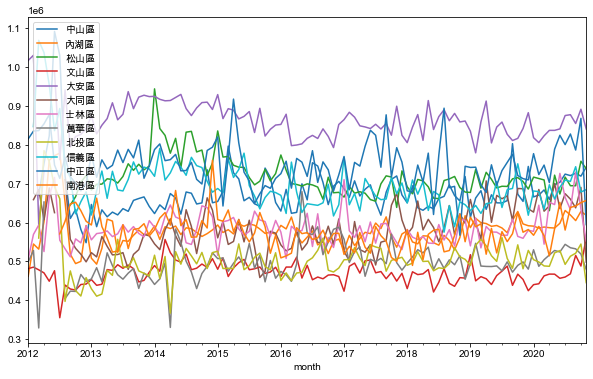

In [843]:
#不使用年平均數據的話 圖表呈現太雜亂
prices = {}
for district in set(df['鄉鎮市區']):
    #使用條件直接篩選離群值
    cond = (
        (df['主要用途'] == '住家用')
        & (df['鄉鎮市區'] == district)
        & (df['單價元坪'] < df["單價元坪"].quantile(0.95))
        & (df['單價元坪'] > df["單價元坪"].quantile(0.05))
        )
    groups = df[cond]['month']
    prices[district] = df[cond]['單價元坪'].astype(float).groupby(groups).mean()
    
price_history = pd.DataFrame(prices)
price_history['2012-01-01':].plot()
plt.legend(loc='upper left')

In [390]:
price_history.columns

Index(['中山區', '內湖區', '松山區', '文山區', '大安區', '大同區', '士林區', '萬華區', '北投區', '信義區',
       '中正區', '南港區'],
      dtype='object')

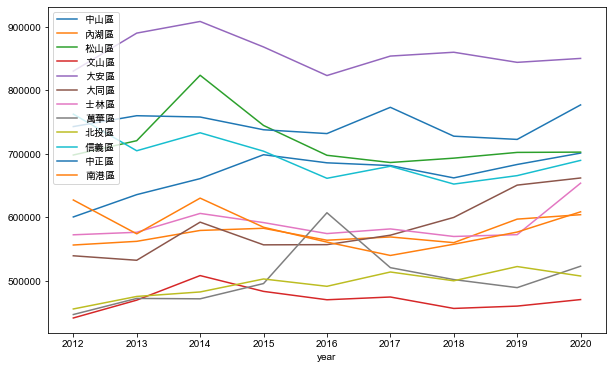

In [842]:
prices = {}
for district in set(df['鄉鎮市區']):
    cond = (
        (df['主要用途'] == '住家用')
        & (df['鄉鎮市區'] == district)
        & (df['單價元坪'] < df["單價元坪"].quantile(0.95))
        & (df['單價元坪'] > df["單價元坪"].quantile(0.05))
        )
    groups = df[cond]['year']
    prices[district] = df[cond]['單價元坪'].astype(float).groupby(groups).mean().loc[2012:]
    
price_history = pd.DataFrame(prices)
price_history.plot()
plt.legend(loc='upper left')

In [392]:
df['主建物坪數']=df['主建物面積']/3.30579

In [393]:
(df['主建物坪數']==0).sum()

19852

In [394]:
df.head()

,Q,主建物面積,主要建材,主要用途,交易年月日,交易標的,交易筆棟數,備註,單價元平方公尺,土地位置建物門牌,...,附屬建物面積,陽台面積,電梯,非都市土地使用分區,非都市土地使用編定,year,單價元坪,建物型態2,month,主建物坪數
1911-12-30,2,0.0,見其他登記事項,停車空間,01230,車位,土地0建物0車位1,NaN,NaN,臺北市南港區忠孝東路六段21號地下三層,...,0.0,0.0,NaN,NaN,NaN,1911,NaN,其他,1911-12-01,0.0
2003-04-15,4,0.0,鋼骨鋼筋混凝土造,見其他登記事項,920415,車位,土地0建物0車位1,NaN,NaN,臺北市大安區光復南路２９０巷２８號地下一層,...,0.0,0.0,NaN,NaN,NaN,2003,NaN,其他,2003-04-01,0.0
2003-10-22,4,0.0,NaN,NaN,921022,土地,土地1建物0車位0,NaN,6653.0,榮星段五小段298地號,...,0.0,0.0,NaN,NaN,NaN,2003,21993.42087,其他,2003-10-01,0.0
2004-04-11,3,0.0,鋼骨鋼筋混凝土造,見其他登記事項,930411,車位,土地0建物0車位1,NaN,NaN,台北市大安區光復南路２９０巷２８號地下一層,...,0.0,0.0,NaN,NaN,NaN,2004,NaN,其他,2004-04-01,0.0
2004-04-11,2,0.0,鋼骨鋼筋混凝土造,見其他登記事項,930411,車位,土地0建物0車位1,NaN,NaN,台北市大安區光復南路２９０巷２８號地下一層,...,0.0,0.0,NaN,NaN,NaN,2004,NaN,其他,2004-04-01,0.0


### 3.3.2將每年的平均物件大小依照台北市各區以折線圖方式簡單呈現歷年走勢

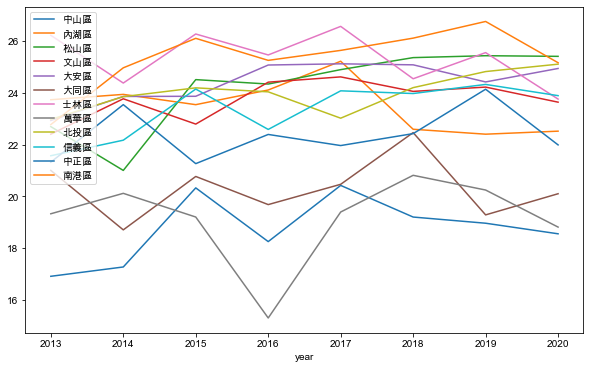

In [858]:
area = {}
for district in set(df['鄉鎮市區']):
   
    cond = (
        (df['主要用途'] == '住家用')
        & (df['鄉鎮市區'] == district)
        & (df['主建物坪數'] < df["主建物坪數"].quantile(0.95))
        & (df['主建物坪數'] > df["主建物坪數"].quantile(0.05))
        )
    groups = df[cond]['year']
    area[district] = df[cond]['主建物坪數'].astype(float).groupby(groups).mean().loc[2012:]
    
    
area_history = pd.DataFrame(area)
area_history.loc[2013:,:].plot()

plt.legend(loc='upper left')

In [859]:
#顯示各年度轉移的房子大小平均
area_history.loc[2013:,:].round(1)

,中山區,內湖區,松山區,文山區,大安區,大同區,士林區,萬華區,北投區,信義區,中正區,南港區
year,,,,,,,,,,,,
2013,16.9,23.7,22.7,22.4,22.9,21.0,26.2,19.3,23.0,21.6,21.3,22.8
2014,17.3,24.0,21.0,23.8,23.9,18.7,24.4,20.1,23.9,22.2,23.6,25.0
2015,20.3,23.6,24.5,22.8,23.9,20.8,26.3,19.2,24.2,24.2,21.3,26.1
2016,18.3,24.1,24.4,24.4,25.1,19.7,25.5,15.3,24.0,22.6,22.4,25.3
2017,20.4,25.2,24.9,24.6,25.1,20.5,26.6,19.4,23.0,24.1,22.0,25.7
2018,19.2,22.6,25.4,24.1,25.1,22.5,24.6,20.8,24.2,24.0,22.4,26.1
2019,19.0,22.4,25.4,24.2,24.4,19.3,25.6,20.2,24.8,24.3,24.2,26.8
2020,18.6,22.5,25.4,23.6,25.0,20.1,23.8,18.8,25.1,23.9,22.0,25.2


### 3.3.3將每年轉移的數量依照台北市各區以折線圖方式簡單呈現歷年走勢

In [426]:
import numpy as np
new=df.groupby(['year','month'])['鄉鎮市區'].value_counts().reset_index(name='counts')

In [427]:
new=new[new['year']>2011]

In [650]:
#手動將缺失的資料先補齊
year=2012
month='2012-07-01'
month=pd.to_datetime(month)

In [651]:
new.loc['1456']= [year,month,'大同區',0]

In [652]:
new['鄉鎮市區'].value_counts()

中正區    107
文山區    107
萬華區    107
中山區    107
信義區    107
內湖區    107
北投區    107
士林區    107
大安區    107
大同區    107
南港區    107
松山區    107
Name: 鄉鎮市區, dtype: int64

In [662]:
new[new['鄉鎮市區']=='大同區'].sort_values(by='month')['month'].tolist()

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2012-02-01 00:00:00'),
 Timestamp('2012-03-01 00:00:00'),
 Timestamp('2012-04-01 00:00:00'),
 Timestamp('2012-05-01 00:00:00'),
 Timestamp('2012-06-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2012-08-01 00:00:00'),
 Timestamp('2012-09-01 00:00:00'),
 Timestamp('2012-10-01 00:00:00'),
 Timestamp('2012-11-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2013-02-01 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2013-04-01 00:00:00'),
 Timestamp('2013-05-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-08-01 00:00:00'),
 Timestamp('2013-09-01 00:00:00'),
 Timestamp('2013-10-01 00:00:00'),
 Timestamp('2013-11-01 00:00:00'),
 Timestamp('2013-12-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00'),
 Timestamp('2014-04-01 00:00:00'),
 Timestamp('2014-05-

In [644]:
idx=(new[new['鄉鎮市區']=='大同區'].sort_values(by='month')['year']==2012).keys()[:13]

In [645]:
new.loc[idx,:]

,year,month,鄉鎮市區,counts
235,2012,2012-02-01 00:00:00,大同區,4
244,2012,2012-03-01 00:00:00,大同區,12
261,2012,2012-04-01 00:00:00,大同區,3
273,2012,2012-05-01 00:00:00,大同區,1
285,2012,2012-06-01 00:00:00,大同區,2
310,2012,2012-08-01 00:00:00,大同區,1
319,2012,2012-09-01 00:00:00,大同區,15
333,2012,2012-10-01 00:00:00,大同區,88
346,2012,2012-11-01 00:00:00,大同區,84
358,2012,2012-12-01 00:00:00,大同區,75


In [789]:
date=new[new['鄉鎮市區']=='大同區'].sort_values(by='month')['month'].tolist()

In [790]:
new

,year,month,鄉鎮市區,counts
359,2013,2013-01-01 00:00:00,中山區,292
360,2013,2013-01-01 00:00:00,內湖區,189
361,2013,2013-01-01 00:00:00,大安區,145
362,2013,2013-01-01 00:00:00,北投區,133
363,2013,2013-01-01 00:00:00,文山區,132
...,...,...,...,...
1495,2020,2020-11-01 00:00:00,中正區,12
1496,2020,2020-11-01 00:00:00,大安區,12
1497,2020,2020-11-01 00:00:00,松山區,11
1498,2020,2020-11-01 00:00:00,大同區,8


#### 以每年四季一折線圖來呈現 看是否有淡旺季之分

In [821]:
a=pd.DataFrame(index=date)
new=new[new['year']>2012]
for district in set(new_['鄉鎮市區']):
    a[district] = new.loc[new['鄉鎮市區']==district].sort_values(by='month')['counts'].values
    
    for year in range(2012,2021):
        inst=a[a.to_period('Y').index==str(year)]
        idx=inst[inst[district]==0].index
        a.loc[idx,district]=a[a.to_period('Y').index==str(year)][district].mean()
        
pd.DataFrame(a)
a=a.astype(int)
a

,中山區,內湖區,南港區,松山區,大安區,大同區,士林區,萬華區,北投區,信義區,中正區,文山區
2013-01-01,292,189,71,109,145,63,102,81,133,130,72,132
2013-02-01,223,120,91,72,125,51,81,56,126,92,56,111
2013-03-01,381,289,124,145,190,101,176,109,192,154,102,191
2013-04-01,397,375,114,137,223,89,175,140,210,154,145,248
2013-05-01,409,343,106,153,240,104,212,125,236,152,136,279
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,133,134,38,64,76,61,88,92,85,51,65,81
2020-08-01,127,143,52,56,68,52,73,69,64,56,63,83
2020-09-01,115,103,44,46,56,27,71,65,74,55,59,55
2020-10-01,120,104,47,34,49,30,49,60,52,51,40,75


In [867]:
a[a.to_period('Y').index=='2020']

,中山區,內湖區,南港區,松山區,大安區,大同區,士林區,萬華區,北投區,信義區,中正區,文山區
2020-01-01,102,82,33,45,38,31,47,45,82,55,49,61
2020-02-01,114,86,34,55,32,39,50,51,73,44,53,49
2020-03-01,134,81,31,49,56,48,62,66,92,69,55,78
2020-04-01,92,112,32,47,56,29,58,72,64,46,59,69
2020-05-01,141,137,43,52,57,66,74,62,73,69,68,103
2020-06-01,147,118,48,65,66,57,93,67,87,75,71,90
2020-07-01,133,134,38,64,76,61,88,92,85,51,65,81
2020-08-01,127,143,52,56,68,52,73,69,64,56,63,83
2020-09-01,115,103,44,46,56,27,71,65,74,55,59,55
2020-10-01,120,104,47,34,49,30,49,60,52,51,40,75


#### 2020年的數據明顯看出轉移的數量明顯萎縮 直覺可以判斷是受到疫情影響

<AxesSubplot:>

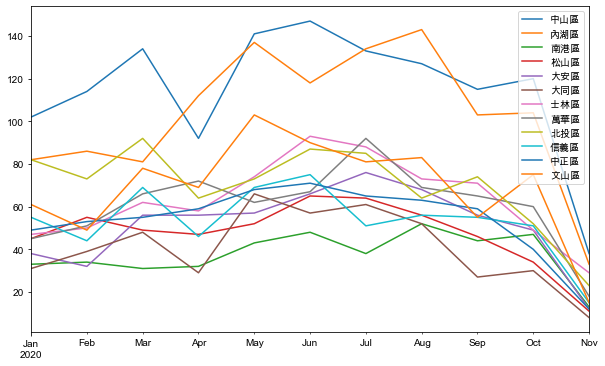

In [865]:
a[a.to_period('Y').index=='2020'].plot()

<AxesSubplot:>

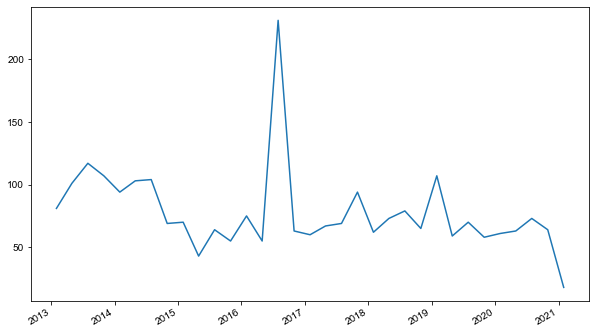

In [868]:
a['萬華區'].resample('3M').mean().astype(int).sort_values(ascending=False).plot()

#### 依照季呈現

<AxesSubplot:>

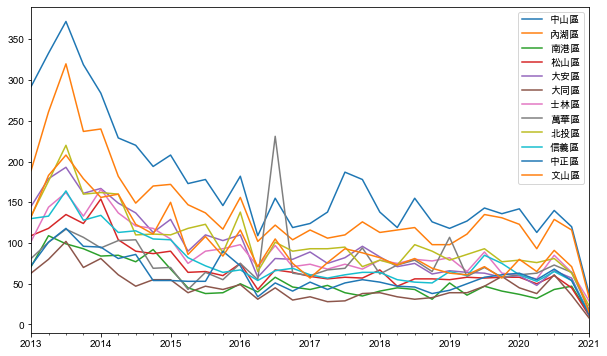

In [827]:
a.resample('3M').mean().astype(int).plot()

In [725]:
a[a.to_period('Y').index=='2012']['中山區'].replace(0,a[a.to_period('Y').index==str(2012)]['中山區'].mean())

2012-01-01      1.000000
2012-02-01     79.166667
2012-03-01      7.000000
2012-04-01      5.000000
2012-05-01     13.000000
2012-06-01      5.000000
2012-07-01      4.000000
2012-08-01     10.000000
2012-09-01     40.000000
2012-10-01    280.000000
2012-11-01    245.000000
2012-12-01    340.000000
Name: 中山區, dtype: float64

In [741]:
b=(a[a.to_period('Y').index=='2012'])

In [744]:
b[b['中山區']==0].index

DatetimeIndex(['2012-02-01'], dtype='datetime64[ns]', freq=None)

In [826]:
#area = {}
#for district in set(df['鄉鎮市區']):
   
 #   cond = (
#        (df['主要用途'] == '住家用')
  #      & (df['鄉鎮市區'] == district)
  #      & (df['主建物坪數'] < df["主建物坪數"].quantile(0.95))
  #      & (df['主建物坪數'] > df["主建物坪數"].quantile(0.05))
   #     )
  #  groups = df[cond]['year']
  #  area[district] = df[cond][district].astype(float).groupby(groups).mean().loc[2012:]
    
#area_history = pd.DataFrame(area)
#area_history.plot()
#plt.legend(loc='upper left')

In [ ]:
# 參考用(使用pivot table 將數據進行轉換)
#total=year_2012.pivot(index='month',columns='鄉鎮市區',values='單價元坪')
#for i in [year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020]:
#    k=i.pivot(index='month',columns='鄉鎮市區',values='單價元坪')
#    total=pd.concat([total,k])
#total

#plt.rcParams['font.sans-serif'] = 'Arial Unicode MS' #設定字型
#plt.rcParams['axes.unicode_minus'] = False
#
#plt.figure(figsize=(16,9))
#for i in total.columns:
#    x= total.index.tolist()
#    y= total[i].values.tolist()
#    plt.plot(x,y,label=i)
#plt.legend()
#plt.show()  